# Regression and Bayes from scratch

## Task 1
Take one of the datasets [here](https://archive.ics.uci.edu/ml/datasets.html?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table)

* Build regression model on it.
* Evaluate quality
* Provide solution as a Jupyter Notebook

### Prepare data

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/My Drive/AI/homework4")

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing

**Dataset Description**

Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

**Dataset characteristics**

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [0]:
bikes = pd.read_csv('bikes.csv')
bikes.dropna(inplace=True)
print(bikes.shape)

(731, 16)


In [0]:
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


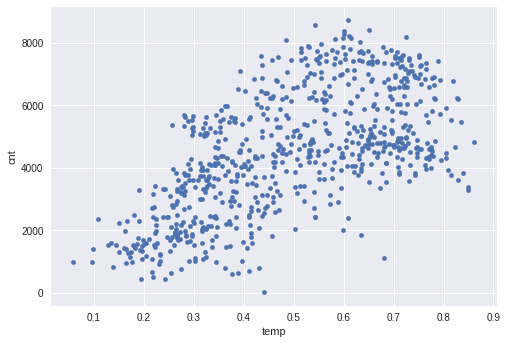

In [0]:
bikes.plot(x="temp", y ='cnt', kind = "scatter")

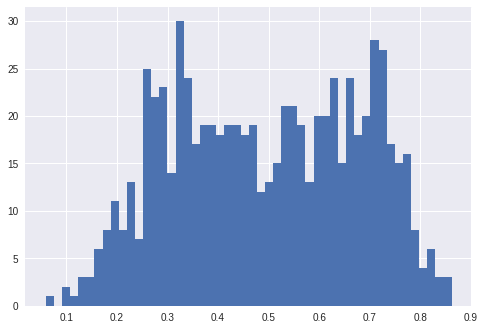

In [0]:
plt.hist(bikes['temp'], 50);

### Finding best features

In [0]:
# Finding features with best correlation with result

bikes_x = bikes.columns[2:-1]
bikes_y = bikes.columns[-1]
print(bikes_x)
correlations = {}

for column in bikes_x:
  correlations[column] = bikes[column].corr(bikes[bikes_y])
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
sorted_correlations

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered'],
      dtype='object')


[('registered', 0.9455169158090357),
 ('casual', 0.6728044333386833),
 ('atemp', 0.631065699849181),
 ('temp', 0.6274940090334918),
 ('yr', 0.5667097078680865),
 ('season', 0.4061003707986365),
 ('mnth', 0.27997711221927124),
 ('weekday', 0.06744341241063045),
 ('workingday', 0.061156063060520655),
 ('holiday', -0.06834771589248408),
 ('hum', -0.1006585621371552),
 ('windspeed', -0.23454499742166993),
 ('weathersit', -0.2973912388346637)]

### Building regression model

In [0]:
# train-test split

msk = np.random.rand(len(bikes)) < 0.8
train = bikes[msk]
test = bikes[~msk]
print(train.shape, test.shape)

X_train = np.asanyarray(train['atemp'])
Y_train = np.asanyarray(train['cnt'])
X_test = np.asanyarray(test['atemp'])
Y_test = np.asanyarray(test['cnt'])


(583, 16) (148, 16)


In [0]:
# initializing our inputs and outputs
X = X_train
Y = Y_train

# mean of our inputs and outputs
x_mean = np.mean(X)
y_mean = np.mean(Y)
#total number of values
n = len(X)
# using the formula to calculate the b1 and b0
numerator = 0
denominator = 0
for i in range(n):
    numerator += (X[i] - x_mean) * (Y[i] - y_mean)
    denominator += (X[i] - x_mean) ** 2

b1 = numerator / denominator
b0 = y_mean - (b1 * x_mean)

print(b1, b0)

7227.184299725206 1071.2283252325424


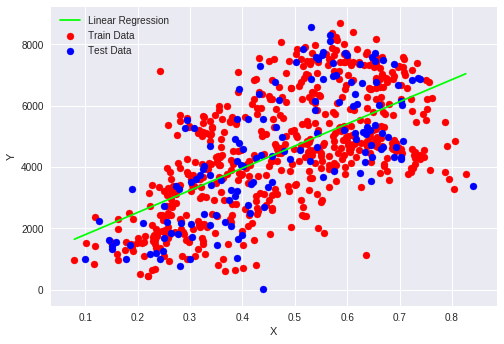

In [0]:
#plotting values 
x_max = np.max(X)
x_min = np.min(X)
#calculating line values of x and y
x = np.linspace(x_min, x_max, 609)
y = b0 + b1 * x
#plotting line 
plt.plot(x, y, color='#00ff00', label='Linear Regression')
#plot the data point
plt.scatter(X, Y, color='#ff0000', label='Train Data')
plt.scatter(X_test, Y_test, color='#0000ff', label='Test Data')
# x-axis label
plt.xlabel('X')
#y-axis label
plt.ylabel('Y')
plt.legend()
plt.show()

In [0]:
# Estimate model quality

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_test_hat = b0 + b1 * X_test

print("Mean absolute error for multiple regression: %.2f" % np.mean(np.absolute(Y_test - y_test_hat)))
print("Residual sum of squares (MSE) for multiple regression: %.2f" % np.mean((Y_test - y_test_hat) ** 2))
print("Sklearn MSE: %.2f" % mean_squared_error(Y_test, y_test_hat))
print("R2-score for multiple regression: %.2f" % r2_score(Y_test, y_test_hat))

Mean absolute error for multiple regression: 1248.17
Residual sum of squares (MSE) for multiple regression: 2286147.16
Sklearn MSE: 2286147.16
R2-score for multiple regression: 0.41


### Exclude outliers

(714, 16)


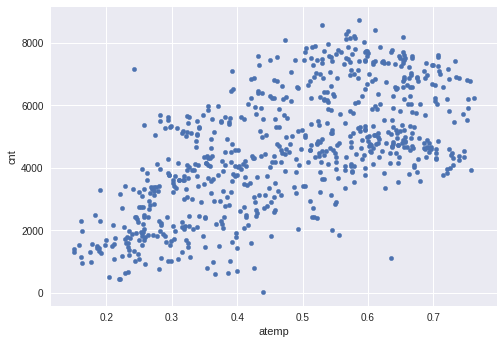

In [0]:
bikes_good = bikes[bikes["atemp"] < 0.78]
bikes_good = bikes_good[np.abs(bikes_good.atemp-bikes_good.atemp.mean()) <= (2*bikes_good.atemp.std())]
print(bikes_good.shape)
bikes_good.plot(x="atemp", y ='cnt', kind = "scatter");

In [0]:
# bikes_good = bikes[np.abs(bikes.atemp-bikes.atemp.mean()) <= (2*bikes.atemp.std())]
# # keep only the ones that are within +2 to -2 standard deviations in the column 'atemp'.
# print(bikes_good.shape)
# bikes_good.plot(x="atemp", y ='cnt', kind = "scatter")

# q = bikes["atemp"].quantile(0.9)
# bikes_good = bikes[bikes["atemp"] < q]
# print(bikes_good.shape)
# bikes_good.plot(x="atemp", y ='cnt', kind = "scatter")

In [0]:
# train-test split

msk = np.random.rand(len(bikes_good)) < 0.8
train2 = bikes_good[msk]
test2 = bikes_good[~msk]
print(train2.shape, test2.shape)

X_train2 = np.asanyarray(train2['atemp'])
Y_train2 = np.asanyarray(train2['cnt'])
X_test2 = np.asanyarray(test2['atemp'])
Y_test2 = np.asanyarray(test2['cnt'])

# initializing our inputs and outputs

X2 = X_train2
Y2 = Y_train2

# mean of our inputs and outputs
x_mean = np.mean(X2)
y_mean = np.mean(Y2)
#total number of values
n = len(X2)
# using the formula to calculate the b1 and b0
numerator = 0
denominator = 0
for i in range(n):
    numerator += (X2[i] - x_mean) * (Y2[i] - y_mean)
    denominator += (X2[i] - x_mean) ** 2

b1 = numerator / denominator
b0 = y_mean - (b1 * x_mean)

print(b1, b0)

(554, 16) (160, 16)
7368.26455286033 1030.1699893624586


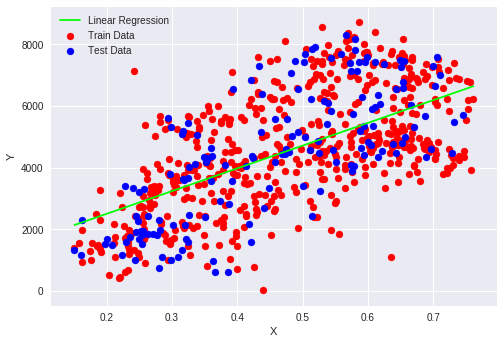

In [0]:
#plotting values 
x_max = np.max(X2)
x_min = np.min(X2)
#calculating line values of x and y
x = np.linspace(x_min, x_max, 600)
y = b0 + b1 * x
#plotting line 
plt.plot(x, y, color='#00ff00', label='Linear Regression')
#plot the data point
plt.scatter(X2, Y2, color='#ff0000', label='Train Data')
plt.scatter(X_test2, Y_test2, color='#0000ff', label='Test Data')
# x-axis label
plt.xlabel('X')
#y-axis label
plt.ylabel('Y')
plt.legend()
plt.show()

In [0]:
y_test_hat = b0 + b1 * X_test2

print("Mean absolute error for multiple regression: %.2f" % np.mean(np.absolute(Y_test2 - y_test_hat)))
print("Residual sum of squares (MSE) for multiple regression: %.2f" % np.mean((Y_test2 - y_test_hat) ** 2))
print("Sklearn MSE: %.2f" % mean_squared_error(Y_test2, y_test_hat))
print("R2-score for multiple regression: %.2f" % r2_score(Y_test2, y_test_hat))

Mean absolute error for multiple regression: 1216.09
Residual sum of squares (MSE) for multiple regression: 2151020.86
Sklearn MSE: 2151020.86
R2-score for multiple regression: 0.50


### Building Polynomial Regression

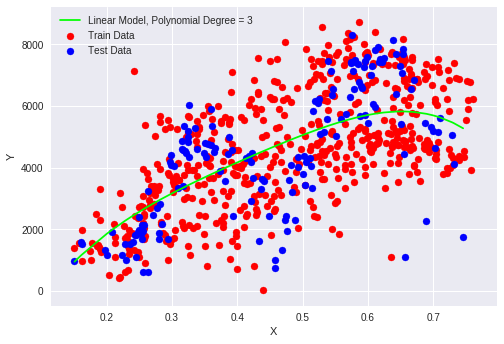

In [0]:
poly = np.polyfit(X_train2, Y_train2, 4)
X_test2 = sorted(X_test2)
y_poly_hat = np.polyval(poly, X_test2)

plt.plot(X_test2, y_poly_hat, label='Linear Model, Polynomial Degree = 3', color='#00ff00')

#plot the data point
plt.scatter(X_train2, Y_train2, color='#ff0000', label='Train Data')
plt.scatter(X_test2, Y_test2, color='#0000ff', label='Test Data')
# x-axis label
plt.xlabel('X')
#y-axis label
plt.ylabel('Y')
plt.legend()
plt.show()


In [0]:
print("Mean absolute error for multiple regression: %.2f" % np.mean(np.absolute(Y_test2 - y_poly_hat)))
print("Residual sum of squares (MSE) for multiple regression: %.2f" % np.mean((Y_test2 - y_poly_hat) ** 2))
print("Sklearn MSE: %.2f" % mean_squared_error(Y_test2, y_poly_hat))
print("R2-score for multiple regression: %.2f" % r2_score(Y_test2, y_poly_hat))

Mean absolute error for multiple regression: 1169.71
Residual sum of squares (MSE) for multiple regression: 2099833.77
Sklearn MSE: 2099833.77
R2-score for multiple regression: 0.51


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


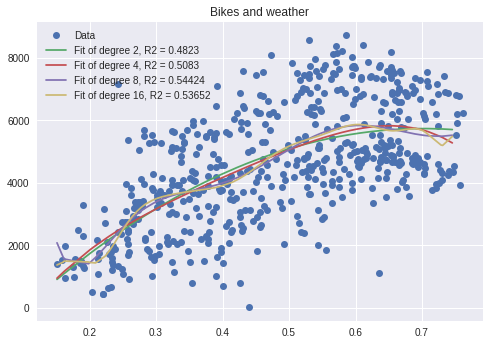

In [0]:
# Finding best polynomial degree

def rSquared(observed, predicted):
    error = ((predicted - observed)**2).sum()
    meanError = error/len(observed)
    return 1 - (meanError/np.var(observed))

def genFits(xVals, yVals, degrees):
    models = []
    for d in degrees:
        model = np.polyfit(xVals, yVals, d)
        models.append(model)
    return models

def testFits(models, degrees, xVals, yVals, xTrain, yTrain, title):
    plt.plot(xTrain, yTrain, 'o', label = 'Data')
    for i in range(len(models)):
        estYVals = np.polyval(models[i], xVals)
        error = rSquared(yVals, estYVals)
        plt.plot(xVals, estYVals,
                   label = 'Fit of degree '\
                   + str(degrees[i])\
                   + ', R2 = ' + str(round(error, 5)))
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show()
    
degrees = (2, 4, 8, 16)
models = genFits(X_train2, Y_train2, degrees)
testFits(models, degrees, X_test2, Y_test2, X_train2, Y_train2, 'Bikes and weather')

## TASK 2

Implement a naive Bayes classifier FROM SCRATCH (no ml libs or fuctions) for text genre classification. Training data can be downloaded from [cloud](https://drive.google.com/open?id=1r3KdeQHlxn-XDKRtISZzbvojq9s7cq_R) 

NOTES:
1. Take well-represented 5-7 categorites
2. If final result is not good, try to exclude a category that is not well separatible from others (try to understand how to do this)
3. Provide the answer as a Jupyter notebook that can perform model training and also porvides an interface function 
 *def predict(text)* that returns a document genre and a dictionary with probabilities for all genres met in training set

### Prepare data

In [0]:
# !unzip ./homework4/*.zip
# !find ./ENGLISH/. -name '*.ZIP' -execdir unzip '{}' ';'

In [0]:
genres = ['ADVENTUR', 'DETECT', 'FANTAST', 'JOURNAL', 'TALES']

In [0]:
import glob
path = 'ENGLISH/'
texts = {}

for genre in genres:
  texts[genre] = {}
  inpath = path + genre
  for filename in glob.glob(os.path.join(inpath, '*.TXT')):    
    try:
      with open(filename, 'r', encoding='utf-8') as f:      
        texts[genre][filename.split('/')[-1]] = ''.join(f.readlines())
      print(filename)
    except:      
      with open(filename, 'r', encoding='latin-1') as f:      
        texts[genre][filename.split('/')[-1]] = ''.join(f.readlines())
      print(filename)

ENGLISH/ADVENTUR/CLOVIS.TXT
ENGLISH/ADVENTUR/CALLWILD.TXT
ENGLISH/ADVENTUR/JUSTDAV.TXT
ENGLISH/ADVENTUR/CANSUCH.TXT
ENGLISH/ADVENTUR/FIRE.TXT
ENGLISH/ADVENTUR/DOUGLASS.TXT
ENGLISH/ADVENTUR/MOBYDICK.TXT
ENGLISH/ADVENTUR/EIGHTY_D.TXT
ENGLISH/ADVENTUR/CAROLCHR.TXT
ENGLISH/ADVENTUR/OPION.TXT
ENGLISH/ADVENTUR/DOUGL2.TXT
ENGLISH/ADVENTUR/ALEXBR.TXT
ENGLISH/ADVENTUR/HFINN.TXT
ENGLISH/ADVENTUR/IVANHOE.TXT
ENGLISH/ADVENTUR/PUDDN.TXT
ENGLISH/ADVENTUR/SAWY2.TXT
ENGLISH/ADVENTUR/SAWY3.TXT
ENGLISH/ADVENTUR/SAWY1.TXT
ENGLISH/ADVENTUR/TARZ1.TXT
ENGLISH/ADVENTUR/TARZ2.TXT
ENGLISH/ADVENTUR/TARZ3.TXT
ENGLISH/ADVENTUR/TARZ4.TXT
ENGLISH/ADVENTUR/TARZ5.TXT
ENGLISH/ADVENTUR/LORD_JIM.TXT
ENGLISH/ADVENTUR/SHARERXT.TXT
ENGLISH/ADVENTUR/2CITY.TXT
ENGLISH/ADVENTUR/BADAM10.TXT
ENGLISH/ADVENTUR/FRDAM10.TXT
ENGLISH/ADVENTUR/GLDNA10.TXT
ENGLISH/ADVENTUR/ISLNI10.TXT
ENGLISH/ADVENTUR/JBARL10.TXT
ENGLISH/ADVENTUR/LMISS11.TXT
ENGLISH/ADVENTUR/MRMEN10.TXT
ENGLISH/ADVENTUR/POLST10.TXT
ENGLISH/ADVENTUR/RFENG10.TXT
ENGLISH/

In [0]:
tcount = 0
for genre in texts:
  print(genre + " : " + str(len(texts[genre])))
  tcount += len(texts[genre])
print('-----')
print('Total :', str(tcount))

ADVENTUR : 39
DETECT : 23
FANTAST : 75
JOURNAL : 8
TALES : 20
-----
Total : 165


In [0]:
# Split texts to train and test subsets

import random

train_texts = {}
test_texts = {}
train_num = 0


for genre in texts:
  train_texts[genre] = {}
  test_texts[genre] = {}
  train_num = int(len(texts[genre])*0.8)
  train_sample = random.sample(texts[genre].keys(), train_num)
  for text in texts[genre]:
    if text in train_sample:
      train_texts[genre][text] = texts[genre][text]
    else:
      test_texts[genre][text] = texts[genre][text]

      
print('Train texts:')      
tcount = 0
for genre in train_texts:
  print(genre + " : " + str(len(train_texts[genre])))
  tcount += len(train_texts[genre])
print('-----')
print('Total :', str(tcount))  

print('\n')    

print('Test texts:')      
tcount = 0
for genre in test_texts:
  print(genre + " : " + str(len(test_texts[genre])))
  tcount += len(test_texts[genre])
print('-----')
print('Total :', str(tcount))  

Train texts:
ADVENTUR : 31
DETECT : 18
FANTAST : 60
JOURNAL : 6
TALES : 16
-----
Total : 131


Test texts:
ADVENTUR : 8
DETECT : 5
FANTAST : 15
JOURNAL : 2
TALES : 4
-----
Total : 34


### Calculate Priors

In [0]:
import math

p_genres = {}
for genre in genres:  
  p_genres[genre] = math.log((len(texts[genre])) / tcount)
p_genres

{'ADVENTUR': 0.13720112151348496,
 'DETECT': -0.39086630868701167,
 'FANTAST': 0.7911275889201491,
 'JOURNAL': -1.4469189829363254,
 'TALES': -0.5306282510621704}

-0.6759065198095777

### Calculate Likelihood

In [0]:
from bs4 import BeautifulSoup
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import re
from nltk.tag import pos_tag
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(sentence):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word
  
def clean_text_lemma(text, lemma=True): 
    ''' 
    Utility function to clean text by removing links, special characters 
    using simple regex statements. Also converting words to lemmas.
    '''    
    text = BeautifulSoup(text, 'html.parser').get_text()    
    stripped_text = re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT\s)", " ", text).lower().split()
    lemma_text = lemmatize_all(stripped_text)
    filtered_text = [word for word in lemma_text if word not in stopWords]
    join_text = ' '.join(filtered_text)
    return join_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def make_bag(text):
  bag = {}
  max_count = 0
  words = text.split()
  
  for word in words:      
    if word in bag:
      bag[word] += 1
    else:
      bag[word] = 1
  
  for word in bag:
    if bag[word] > max_count:
      max_count = bag[word]
  
  #for word in bag:
  #  bag[word] = (float(bag[word]) / len(words)) * 100
  
  for word in bag:
    bag[word] = (float(bag[word]) / max_count) * 100
  
  return bag

In [0]:
# Clean train text and count words per text

p_word = {}
for genre in train_texts:
  p_word[genre] = {}
  for text in train_texts[genre]:    
    train_texts[genre][text] = clean_text_lemma(train_texts[genre][text])
    p_word[genre][text] = make_bag(train_texts[genre][text])    
    print(text)

In [0]:
#texts["FANTAST"]['EMPLANET.TXT']

In [0]:
# bag_planet = make_bag(texts["FANTAST"]['EMPLANET.TXT'])
# bag_planet

In [0]:
# Save bag of words to file to use it again
import pickle

def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
      

In [0]:
#save_obj(p_word, "bagofwords5")
p_word = load_obj("bagofwords5")

len(p_word['DETECT'])

18

In [0]:
# Gather mean and variance per word per genre

p_word_stat = {}
all_words = set()

for genre in p_word:  
  p_word_stat[genre] = {}
  
  for text in p_word[genre]:   
    for word in p_word[genre][text]:
      all_words.add(word)
      
      if word in p_word_stat[genre]:
        p_word_stat[genre][word]['values'] = np.append(p_word_stat[genre][word]['values'], p_word[genre][text][word])
      else:
        p_word_stat[genre][word] = {}
        p_word_stat[genre][word]['values'] = np.array([p_word[genre][text][word]])
        
  for word in p_word_stat[genre]:
    if len(p_word_stat[genre][word]['values']) < len(p_word[genre]):      
      dif = len(p_word[genre]) - len(p_word_stat[genre][word]['values'])      
      p_word_stat[genre][word]['values'] = np.pad(p_word_stat[genre][word]['values'], (0,dif), 'constant')
    
    p_word_stat[genre][word]['mean'] = p_word_stat[genre][word]['values'].mean()
    p_word_stat[genre][word]['var'] = p_word_stat[genre][word]['values'].var()
    p_word_stat[genre][word]['std'] = p_word_stat[genre][word]['values'].std()
  
  print(len(p_word[genre]))

31
18
60
6
16


In [0]:
print('Number of words per genre\n')

for genre in p_word_stat:
  print(genre, " : ", len(p_word_stat[genre]))

Number of words per genre

ADVENTUR  :  33929
DETECT  :  24706
FANTAST  :  45532
JOURNAL  :  37932
TALES  :  16272


In [0]:
print("Total number of words:")
all_len = len(all_words)
print(all_len)


Total number of words:
81968


In [0]:
v = p_word_stat["DETECT"]["sherlock"]['std']

print("Sherlock mean: {0:8.20f}".format(v))
print(p_word_stat["DETECT"]["sherlock"]['values'])

Sherlock mean: 5.67049678816878088838
[ 2.43902439  9.10569106  9.97304582  5.51724138 11.76470588 19.91869919
  9.18836141  0.47732697  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


In [0]:
count = 3
for item in p_word_stat['DETECT']:
  print(item)
  print(p_word_stat['DETECT'][item])
  count -= 1
  if count == 0:
    break

obi
{'values': array([0.22172949, 0.32520325, 0.26954178, 0.17241379, 0.1020929 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ]), 'mean': 0.06061006770427873, 'var': 0.011199940231871604, 'std': 0.1058297700643425}
doyle
{'values': array([0.22172949, 0.32520325, 0.53908356, 0.51724138, 0.34602076,
       0.40650407, 1.12302195, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ]), 'mean': 0.19326691419874012, 'var': 0.08816040382246365, 'std': 0.29691817698225154}
valley
{'values': array([11.0864745 ,  0.32520325,  2.84552846,  2.22222222,  3.16488004,
        0.1305483 ,  0.10493179,  0.38961039,  0.6103764 ,  0.50890585,
        7.37864078,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ]), 'mean': 1.59818455478871

In [0]:
import sys
fmin = sys.float_info.min
fmin


2.2250738585072014e-308

In [0]:
import math

def calculateProbability(x, mean, stdev):
  exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
  return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent


def naive_product(text_bag, class_stats):
  naive_p = 1
  for word in text_bag:
    try:
      p = calculateProbability(text_bag[word], class_stats[word]['mean'], class_stats[word]['std'])
      p = math.log(p)
    except:
      p = math.log(2.2250738585072014e-250)
      
    if not p == 0.0:      
      naive_p += p      
    else:
      naive_p += math.log(2.2250738585072014e-250)
      #print(naive_p)
  return naive_p
      

In [0]:
def predict(text, priors=p_genres, classes=genres, word_stats=p_word_stat, short=False):
  predictions = {}
  text_lemma = clean_text_lemma(text)
  text_bag = make_bag(text_lemma)  
  
  for genre in classes:
    prediction = priors[genre] + naive_product(text_bag, word_stats[genre])
    predictions[genre] = prediction
  sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
  if short == True:
    return sorted_predictions[0][0]
  else:
    return sorted_predictions 

In [0]:
alice = ''.join(open('alice.txt', 'r').readlines())

predicted_genre = predict(alice)
predicted_genre

[('DETECT', -74908.99095707077),
 ('FANTAST', -82940.88325451959),
 ('TALES', -87843.43001024672),
 ('ADVENTUR', -91815.62102402758),
 ('JOURNAL', -105875.95655661015)]

In [0]:
sherlock = "Sherlock was surprised by this murder. Watson, we need to discuss the story of this victim's murder. I know who is the killer!"

predicted_genre = predict(sherlock)
predicted_genre

[('DETECT', -3000.090694569574),
 ('JOURNAL', -3173.382427199093),
 ('FANTAST', -3868.5447572460243),
 ('ADVENTUR', -4026.711821415011),
 ('TALES', -4184.214898251618)]

In [0]:
cosmos = "Jedi Luke showed to Yoda his new lightsaber and Dart Vader arrives. Princess Leia, help us!"
predicted_genre = predict(cosmos)
predicted_genre

[('FANTAST', -4143.873308735331),
 ('JOURNAL', -5672.778164760763),
 ('TALES', -5952.422561728007),
 ('ADVENTUR', -6415.458681361486),
 ('DETECT', -6826.844709901755)]

In [0]:
text_lemma = clean_text_lemma(alice)
text_bag = make_bag(text_lemma)
naive_product(text_bag, p_word_stat['DETECT'])

-8967.973666908447

### Estimate model

In [0]:
df = pd.DataFrame(columns=['labels', 'predicted', 'correct'])

total = 0
guessed = 0
predicted = ''
for genre in test_texts:
  print("Predict", genre)
  for text in test_texts[genre]:
    total += 1
    prediction = predict(test_texts[genre][text])
    predicted = prediction[0][0]
    df = df.append({'labels': genre, 'predicted': predicted, 'correct': genre==predicted}, ignore_index=True)
    print(prediction)
    if predicted == genre:
      guessed += 1    

Predict ADVENTUR
[('ADVENTUR', -7350.291547038683), ('FANTAST', -199610.93035125398), ('DETECT', -286241.0249147931), ('JOURNAL', -291960.0442172962), ('TALES', -365499.0467528624)]
[('ADVENTUR', -12589.896702852891), ('FANTAST', -248460.177213426), ('DETECT', -327186.698595024), ('JOURNAL', -401209.87793600117), ('TALES', -563313.9930240097)]
[('ADVENTUR', -6783.856783406289), ('FANTAST', -123411.23906952041), ('DETECT', -153839.84263882908), ('JOURNAL', -227363.85448479574), ('TALES', -290774.89811315754)]
[('ADVENTUR', -13894.494968005654), ('FANTAST', -330398.3762626964), ('DETECT', -417573.4230665772), ('JOURNAL', -486177.7683475163), ('TALES', -595650.6568867869)]
[('ADVENTUR', -12768.275505931899), ('FANTAST', -175890.1076072102), ('DETECT', -234377.60009002817), ('JOURNAL', -279896.2631909328), ('TALES', -349071.03703744954)]
[('ADVENTUR', -16458.786890915075), ('FANTAST', -401335.0164325448), ('DETECT', -502349.22320811154), ('JOURNAL', -543116.2316149888), ('TALES', -781394.2

In [0]:
print("Model accuracy:", "{0:8.2f}".format(guessed / total))

Model accuracy:     0.91


In [0]:
df.head()

,labels,predicted,correct
0,ADVENTUR,ADVENTUR,True
1,ADVENTUR,ADVENTUR,True
2,ADVENTUR,ADVENTUR,True
3,ADVENTUR,ADVENTUR,True
4,ADVENTUR,ADVENTUR,True


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

def find_f1(label):
  true_positives = len(df[(df['correct'] == True) & (df['labels'] == label)])  
  false_negatives = len(df[(df['correct'] == False) & (df['labels'] == label)])  
  false_positives = len(df[(df['correct'] == False) & (df['predicted'] == label)])
                           
  precision = true_positives / (true_positives + false_positives)  
  recall = true_positives / (true_positives + false_negatives)  
  f1 = 2 * ((precision*recall) / (precision + recall))
  return f1

print('Homemade Report:')
f1_total = 0
for genre in genres:
  f1 = round(find_f1(genre), 2)
  print('F1 for {0}'.format(genre), f1)
  f1_total += f1
print('Total:', round(f1_total/len(genres), 2))
  
  
print('\n')
print('Sklearn Report:')
print(classification_report(df['labels'], df['predicted']))

Homemade Report:
F1 for ADVENTUR 0.94
F1 for DETECT 0.89
F1 for FANTAST 0.94
F1 for JOURNAL 1.0
F1 for TALES 0.67
Total: 0.89


Sklearn Report:
             precision    recall  f1-score   support

   ADVENTUR       0.89      1.00      0.94         8
     DETECT       1.00      0.80      0.89         5
    FANTAST       0.88      1.00      0.94        15
    JOURNAL       1.00      1.00      1.00         2
      TALES       1.00      0.50      0.67         4

avg / total       0.92      0.91      0.90        34



In [0]:
cnf_matrix = confusion_matrix(df['labels'], df['predicted'], labels=genres)
print(cnf_matrix)

[[ 8  0  0  0  0]
 [ 0  4  1  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0  2  0]
 [ 1  0  1  0  2]]


In [0]:
import itertools
%matplotlib inline
from matplotlib import pyplot as plt
	
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


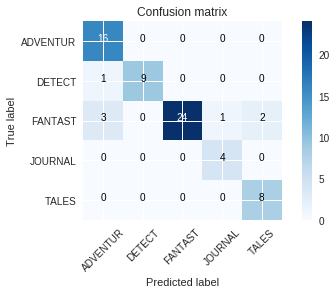

In [0]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=genres, normalize=False,  title='Confusion matrix')

### Predict genre of twits

In [0]:
utwits = pd.read_csv("../c_ukraine.tsv", sep='\t')

In [0]:
utwits.head()

,text,src,user_location,country,created_at
0,RT @MrSandy_P: @ottocrat On the first skim rea...,twitter,riding a unicorn on the moon,NaN,1540984571
1,RT @ottocrat: I wonder what the result would h...,twitter,riding a unicorn on the moon,NaN,1540984573
2,RT @SwedenUN: #Russia’s aggression against #Uk...,twitter,"Toronto, Ontario",NaN,1540984577
3,"RT @tccandler: NICK BATEMAN (Canada), LAY (Chi...",twitter,NaN,NaN,1540984586
4,@tccandler @_MELOVIN_ I vote for #Melovin @_ME...,twitter,"Kijów, LA, Odessa, Warszawa",NaN,1540984640


In [0]:
utwits['genre'] = utwits['text'].apply(lambda x: predict(x, short=True))

In [0]:
utwits.head()

,text,src,user_location,country,created_at,genre
0,RT @MrSandy_P: @ottocrat On the first skim rea...,twitter,riding a unicorn on the moon,NaN,1540984571,FANTAST
1,RT @ottocrat: I wonder what the result would h...,twitter,riding a unicorn on the moon,NaN,1540984573,FANTAST
2,RT @SwedenUN: #Russia’s aggression against #Uk...,twitter,"Toronto, Ontario",NaN,1540984577,JOURNAL
3,"RT @tccandler: NICK BATEMAN (Canada), LAY (Chi...",twitter,NaN,NaN,1540984586,JOURNAL
4,@tccandler @_MELOVIN_ I vote for #Melovin @_ME...,twitter,"Kijów, LA, Odessa, Warszawa",NaN,1540984640,JOURNAL


In [0]:
utwits['genre'].value_counts()

FANTAST     1898
JOURNAL     1329
ADVENTUR     491
TALES        333
DETECT        41
Name: genre, dtype: int64

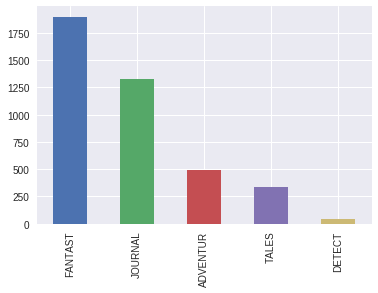

In [0]:
utwits['genre'].value_counts().plot(kind="bar")

In [0]:
itwits = pd.read_csv('../twitbase2.tsv', sep='\t')

In [0]:
itwits.head()

,text,src,coordinates,place,created_at
0,"RT @europecoinEUORG: ""cloudy"" perspective FINA...",twitter,NaN,NaN,1540335991
1,RT @moonemotion: #5G will move massive amounts...,twitter,NaN,NaN,1540335991
2,RT @udacity: Hours left to apply for the @PyTo...,twitter,NaN,NaN,1540335996
3,RT @MikeQuindazzi: #AI and #IoT the most relev...,twitter,NaN,NaN,1540335997
4,RT @rajat_shrimal: This futuristic bus is 100%...,twitter,NaN,NaN,1540335998


In [0]:
itwits['genre'] = itwits['text'].apply(lambda x: predict(x, short=True))

In [0]:
itwits.head()

,text,src,coordinates,place,created_at,genre
0,"RT @europecoinEUORG: ""cloudy"" perspective FINA...",twitter,NaN,NaN,1540335991,ADVENTUR
1,RT @moonemotion: #5G will move massive amounts...,twitter,NaN,NaN,1540335991,FANTAST
2,RT @udacity: Hours left to apply for the @PyTo...,twitter,NaN,NaN,1540335996,JOURNAL
3,RT @MikeQuindazzi: #AI and #IoT the most relev...,twitter,NaN,NaN,1540335997,JOURNAL
4,RT @rajat_shrimal: This futuristic bus is 100%...,twitter,NaN,NaN,1540335998,JOURNAL


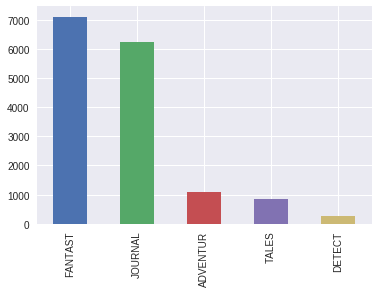

In [0]:
itwits['genre'].value_counts().plot(kind="bar")